# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Mon, March 01, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius <christopher.lucasius@mail.utoronto.ca>

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1BO681Cl_zB5_cyyyJSPvS_rZSO8fPkvo/view?usp=sharing

In [29]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import tensorflow as tf
import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [30]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [31]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [32]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [33]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [34]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [35]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [36]:
#For each of the columns ["age", "yredu", "capgain", "caploss", "workhr"], report the minimum, maximum, and average value across the dataset.
def getMinMaxAvgInformation(colName):
  minCalculation = min(subdf[colName])
  maxCalculation = max(subdf[colName])
  avgCalculation = sum(subdf[colName])/len(subdf[colName])

  print("The minimum", colName, "is", minCalculation)
  print("The maximum", colName, "is", maxCalculation)
  print("The average", colName, "is", avgCalculation)
  print('\n')

getMinMaxAvgInformation('age')
getMinMaxAvgInformation('yredu')
getMinMaxAvgInformation('capgain')
getMinMaxAvgInformation('caploss')
getMinMaxAvgInformation('workhr')

The minimum age is 17
The maximum age is 90
The average age is 38.58164675532078


The minimum yredu is 1
The maximum yredu is 16
The average yredu is 10.0806793403151


The minimum capgain is 0
The maximum capgain is 99999
The average capgain is 1077.6488437087312


The minimum caploss is 0
The maximum caploss is 4356
The average caploss is 87.303829734959


The minimum workhr is 1
The maximum workhr is 99
The average workhr is 40.437455852092995




In [37]:
#Then, normalize each of the features ["age", "yredu", "capgain", "caploss", "workhr"] so that their values are always between 0 and 1. 
#Make sure that you are actually modifying the dataframe df.

df["age"] = (df["age"] - (df["age"]).min())/((df["age"]).max() - (df["age"]).min())
df["yredu"] = (df["yredu"] - (df["yredu"]).min())/((df["yredu"]).max() - (df["yredu"]).min())
df["capgain"] = (df["capgain"] - (df["capgain"]).min())/((df["capgain"]).max() - (df["capgain"]).min())
df["caploss"] = (df["caploss"] - (df["caploss"]).min())/((df["caploss"]).max() - (df["caploss"]).min())
df["workhr"] = (df["workhr"] - (df["workhr"]).min())/((df["workhr"]).max() - (df["workhr"]).min())

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [38]:
# hint: you can do something like this in pandas
numMales = sum(df["sex"] == " Male")
ans1 = (numMales*100)/len(df["sex"])

numFemales = sum(df["sex"] == " Female")
ans2 = (numFemales*100)/len(df["sex"])

print("The percentage of people that are males in our dataset is:", ans1, "%")
print("The percentage of people that are females in our dataset is:", ans2, "%")

The percentage of people that are males in our dataset is: 66.92054912318417 %
The percentage of people that are females in our dataset is: 33.07945087681582 %


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [39]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [40]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [41]:
print(len(df_with_missing), "records contained missing information")
print((len(df_with_missing)*100/len(df)), "% of the records were removed")

1843 records contained missing information
5.660145572924664 % of the records were removed


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [42]:
workTypes = set()

for x in df_not_missing['work']:
  workTypes.add(x)

print("All the possible values of the feature 'work' in df_not_missing are: ")
for c in workTypes:
  print(c)

All the possible values of the feature 'work' in df_not_missing are: 
 Federal-gov
 Self-emp-inc
 Local-gov
 Without-pay
 State-gov
 Self-emp-not-inc
 Private


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [43]:
data = pd.get_dummies(df_not_missing)

In [44]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [45]:
data.shape

(30718, 57)

There are 57 columns or features in the dataframe 'data'. The function, 'get_dummies', transferred strings in data set to values of 0 and 1. Now we have one column representing each possible outcome for things like work. Now we only need 0s and 1s to represent all the information.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [46]:
datanp = data.values.astype(np.float32)

In [47]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    index = np.where(onehot == onehot.max())[0][0]
    return cat_values[feature][index]

In [48]:
print("Cat_index information:", cat_index, "\n")
print("Cat_values information:", cat_values)

Cat_index information: {'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55} 

Cat_values information: {'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']}


In [49]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [50]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
indices = np.arange(len(data))
np.random.shuffle(indices)

dataSplit1 = int(len(indices) * 0.70)
dataSplit2 = int(len(indices) * 0.85)

trainingIndices = indices[:dataSplit1]
validationIndices = indices[dataSplit1:dataSplit2]
testingIndices = indices[dataSplit2:]

trainingData = datanp[trainingIndices]
validationData = datanp[validationIndices]
testingData = datanp[testingIndices]

print("The length of training data is:", len(trainingData))
print("The length of validation data is:", len(validationIndices))
print("The length of testing data is:", len(testingData))

The length of training data is: 21502
The length of validation data is: 4608
The length of testing data is: 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [51]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(57, 30),
            nn.ReLU(),
            nn.Linear(30, 15)
        )
        self.decoder = nn.Sequential(
            nn.Linear(15, 30), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(30, 57),
            nn.ReLU(),
            nn.Linear(57, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

In [ ]:
'''
The sigmoid activation in the last step of the decoder forces the output returned to be values
between 0 to 1. This is neccesarry because the data in the columns is normalized as well.
Therefore, we want the output of the encoder to match this.
'''

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, batch_size = 128, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    #Store the accuracy in the array
    trainingAccuracy = []
    validationAccuracy = []

    #Store the loss in an array
    trainingLosses = []

    for epoch in range(num_epochs):
        i = 1
        for data in train_loader:
            if torch.cuda.is_available():
                data = data.cuda()
                model.cuda()

            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if i%40 == 0:
                trainingAccuracy.append(get_accuracy(model, train_loader))
                validationAccuracy.append(get_accuracy(model, valid_loader))
                trainingLosses.append(float(loss)/batch_size)
                
                #print("Epoch:", epoch + 1, ", Training Accuracy:", trainingAccuracy[-1], ", Validation Accuracy:", validationAccuracy[-1])
                print("Epoch:", epoch + 1, ", Iteration:", i, ", Training Accuracy:", trainingAccuracy[-1], ", Validation Accuracy:", validationAccuracy[-1])
            i += 1

    trainingAccuracy.append(get_accuracy(model, train_loader))
    validationAccuracy.append(get_accuracy(model, valid_loader))
    trainingLosses.append(float(loss)/batch_size)
    print("Epoch:", epoch + 1, ", Training Accuracy:", trainingAccuracy[-1], ", Validation Accuracy:", validationAccuracy[-1])

'''
    #Accuracy Plot
    plt.title("Training Curve")
    plt.plot(trainingAccuracy, label='Training')
    plt.plot(validationAccuracy, label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.show()

    #Loss Plot
    plt.title('Training Curve')
    plt.plot(trainingLosses, label='Training')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()
'''

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [54]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
          #Allow GPUs to be used
          if torch.cuda.is_available():
            item = item.cuda()
            model.cuda()

            inp = item.detach().cuda().cpu().numpy()
            out = model(zero_out_feature(item.clone(), col).cuda()).detach().cpu().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Using CUDA!
Epoch: 1 , Iteration: 40 , Training Accuracy: 0.3638111183455803 , Validation Accuracy: 0.3621961805555556
Epoch: 1 , Iteration: 80 , Training Accuracy: 0.4598486962453105 , Validation Accuracy: 0.4585503472222222
Epoch: 1 , Iteration: 120 , Training Accuracy: 0.458608501534741 , Validation Accuracy: 0.4577907986111111
Epoch: 1 , Iteration: 160 , Training Accuracy: 0.46256162217468144 , Validation Accuracy: 0.4615162037037037
Epoch: 2 , Iteration: 40 , Training Accuracy: 0.458608501534741 , Validation Accuracy: 0.4578269675925926
Epoch: 2 , Iteration: 80 , Training Accuracy: 0.526594425324776 , Validation Accuracy: 0.5275607638888888
Epoch: 2 , Iteration: 120 , Training Accuracy: 0.5627461011378786 , Validation Accuracy: 0.5632957175925926
Epoch: 2 , Iteration: 160 , Training Accuracy: 0.5672263045298112 , Validation Accuracy: 0.5671296296296297
Epoch: 3 , Iteration: 40 , Training Accuracy: 0.5714352153288066 , Validation Accuracy: 0.5721571180555556
Epoch: 3 , Iteration: 8

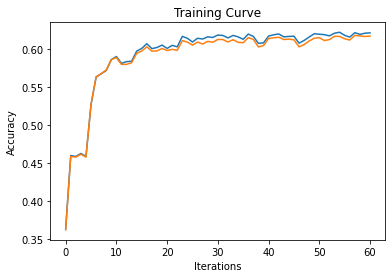

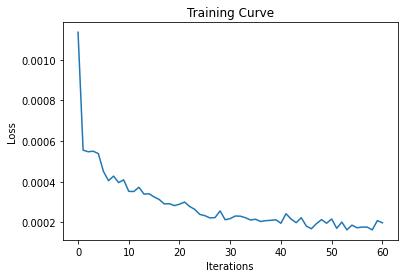

In [57]:
autoEncoderModel = AutoEncoder()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  autoEncoderModel.cuda()
  print('Using CUDA!')
else:
  print('Not using CUDA!')

batch_size=128
train_loader = torch.utils.data.DataLoader(trainingData, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validationData, batch_size=batch_size, shuffle=True)
train(autoEncoderModel, train_loader, valid_loader, batch_size=batch_size, num_epochs=15, learning_rate=0.001)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

In [59]:
#In my first iteration of the model, I will be lowering the batch_size to 64, and decreasing
#the number of epochs
#My thinking behind this is that smaller batches can go through quicker with less variablility
autoEncoderModel1 = AutoEncoder()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  autoEncoderModel1.cuda()
  print('Using CUDA!')
else:
  print('Not using CUDA!')

batch_size=64
train_loader = torch.utils.data.DataLoader(trainingData, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validationData, batch_size=batch_size, shuffle=True)
train(autoEncoderModel1, train_loader, valid_loader, batch_size=batch_size, num_epochs=10, learning_rate=0.001)

Using CUDA!
Epoch: 1 , Iteration: 40 , Training Accuracy: 0.3778098161411342 , Validation Accuracy: 0.37666377314814814
Epoch: 1 , Iteration: 80 , Training Accuracy: 0.45512045391126404 , Validation Accuracy: 0.4541015625
Epoch: 1 , Iteration: 120 , Training Accuracy: 0.4587712770905032 , Validation Accuracy: 0.4568504050925926
Epoch: 1 , Iteration: 160 , Training Accuracy: 0.4598486962453105 , Validation Accuracy: 0.4585503472222222
Epoch: 1 , Iteration: 200 , Training Accuracy: 0.45907357455120457 , Validation Accuracy: 0.4578993055555556
Epoch: 1 , Iteration: 240 , Training Accuracy: 0.49852726878119863 , Validation Accuracy: 0.49692563657407407
Epoch: 1 , Iteration: 280 , Training Accuracy: 0.5491737202740831 , Validation Accuracy: 0.5506727430555556
Epoch: 1 , Iteration: 320 , Training Accuracy: 0.5559327814466871 , Validation Accuracy: 0.5550491898148148
Epoch: 2 , Iteration: 40 , Training Accuracy: 0.5636529935199827 , Validation Accuracy: 0.5644169560185185
Epoch: 2 , Iteration

As we can see above, the training accuracy and the validation accuracy slightly decreased. I will increase the number of epochs a little to allow longer training. I also want to increase the learning rate and see whether this has any benefits.

In [60]:
#In my second iteration of the model, I will be increasing the learning rate to 0.005, and increasing the 
#number of epochs to 12
autoEncoderModel2 = AutoEncoder()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  autoEncoderModel2.cuda()
  print('Using CUDA!')
else:
  print('Not using CUDA!')

batch_size=64
train_loader = torch.utils.data.DataLoader(trainingData, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validationData, batch_size=batch_size, shuffle=True)
train(autoEncoderModel2, train_loader, valid_loader, batch_size=batch_size, num_epochs=12, learning_rate=0.005)

Using CUDA!
Epoch: 1 , Iteration: 40 , Training Accuracy: 0.4417651071218181 , Validation Accuracy: 0.4409722222222222
Epoch: 1 , Iteration: 80 , Training Accuracy: 0.493775772796329 , Validation Accuracy: 0.49171730324074076
Epoch: 1 , Iteration: 120 , Training Accuracy: 0.5546693330852944 , Validation Accuracy: 0.5542173032407407
Epoch: 1 , Iteration: 160 , Training Accuracy: 0.5569171859982017 , Validation Accuracy: 0.5591724537037037
Epoch: 1 , Iteration: 200 , Training Accuracy: 0.5847595572504883 , Validation Accuracy: 0.5831886574074074
Epoch: 1 , Iteration: 240 , Training Accuracy: 0.5979908845688773 , Validation Accuracy: 0.5920500578703703
Epoch: 1 , Iteration: 280 , Training Accuracy: 0.5959833193811428 , Validation Accuracy: 0.5927372685185185
Epoch: 1 , Iteration: 320 , Training Accuracy: 0.6052692772765325 , Validation Accuracy: 0.6034794560185185
Epoch: 2 , Iteration: 40 , Training Accuracy: 0.6005952934610734 , Validation Accuracy: 0.5974754050925926
Epoch: 2 , Iteratio

As you can see above, both the training accuracy and the validation increased due to the increase in the learning rate. Therefore, I will be keeping all the other hyperparameters constant, and I will be increasing the learning eate even more. I expect the accuracy to increase even more, or fall again.

In [61]:
#In my third iteration of the model, I will be increasing the learning rate to 0.01, and will be keeping 
#other hyperparameters the same
autoEncoderModel3 = AutoEncoder()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  autoEncoderModel3.cuda()
  print('Using CUDA!')
else:
  print('Not using CUDA!')

batch_size=64
train_loader = torch.utils.data.DataLoader(trainingData, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validationData, batch_size=batch_size, shuffle=True)
train(autoEncoderModel3, train_loader, valid_loader, batch_size=batch_size, num_epochs=12, learning_rate=0.01)

Using CUDA!
Epoch: 1 , Iteration: 40 , Training Accuracy: 0.4598486962453105 , Validation Accuracy: 0.4585503472222222
Epoch: 1 , Iteration: 80 , Training Accuracy: 0.5207345053173348 , Validation Accuracy: 0.5223524305555556
Epoch: 1 , Iteration: 120 , Training Accuracy: 0.5619089697082442 , Validation Accuracy: 0.5625723379629629
Epoch: 1 , Iteration: 160 , Training Accuracy: 0.560459492140266 , Validation Accuracy: 0.5614872685185185
Epoch: 1 , Iteration: 200 , Training Accuracy: 0.5799925588317366 , Validation Accuracy: 0.5777994791666666
Epoch: 1 , Iteration: 240 , Training Accuracy: 0.6008278299693052 , Validation Accuracy: 0.6000072337962963
Epoch: 1 , Iteration: 280 , Training Accuracy: 0.5884646389483149 , Validation Accuracy: 0.5831886574074074
Epoch: 1 , Iteration: 320 , Training Accuracy: 0.6013704151551794 , Validation Accuracy: 0.5988859953703703
Epoch: 2 , Iteration: 40 , Training Accuracy: 0.5887669364090162 , Validation Accuracy: 0.5828993055555556
Epoch: 2 , Iteration

After increasing the learning rate to 0.01, I see high variance and the accuracies decreased from the second model. For my fourth and final attempt, I will lower the learning rate slightly to 0.0075. I will also try to increase the batch size to 75. Lastly, I want to increase the number of epochs to 20 to allow for an even longer training period.

In [64]:
#In my fourth iteration of the model, I will be decreasing the learning rate to 0.0075, I will also 
#increase the batch size to 75 and will be also increasing the number of epochs to 20 to allow for a 
#longer training time
autoEncoderModel4 = AutoEncoder()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  autoEncoderModel4.cuda()
  print('Using CUDA!')
else:
  print('Not using CUDA!')

batch_size=75
train_loader = torch.utils.data.DataLoader(trainingData, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validationData, batch_size=batch_size, shuffle=True)
train(autoEncoderModel4, train_loader, valid_loader, batch_size=batch_size, num_epochs=20, learning_rate=0.0075)

Using CUDA!
Epoch: 1 , Iteration: 40 , Training Accuracy: 0.4578256286236939 , Validation Accuracy: 0.4564525462962963
Epoch: 1 , Iteration: 80 , Training Accuracy: 0.5470808916999969 , Validation Accuracy: 0.5498046875
Epoch: 1 , Iteration: 120 , Training Accuracy: 0.5630871546832853 , Validation Accuracy: 0.5641276041666666
Epoch: 1 , Iteration: 160 , Training Accuracy: 0.5842092208476731 , Validation Accuracy: 0.5808015046296297
Epoch: 1 , Iteration: 200 , Training Accuracy: 0.5845270207422565 , Validation Accuracy: 0.5844184027777778
Epoch: 1 , Iteration: 240 , Training Accuracy: 0.5970142312343037 , Validation Accuracy: 0.5956669560185185
Epoch: 1 , Iteration: 280 , Training Accuracy: 0.5959445632964375 , Validation Accuracy: 0.5960286458333334
Epoch: 2 , Iteration: 40 , Training Accuracy: 0.5940920224475242 , Validation Accuracy: 0.5915436921296297
Epoch: 2 , Iteration: 80 , Training Accuracy: 0.5997271571636748 , Validation Accuracy: 0.5961733217592593
Epoch: 2 , Iteration: 120 

As you can see above this combination of the hyperparameters had the highest final training accuracy of 63.70% and validation accuracy of 63.33%. This is the model I will be using for the testing stage in Part 4. 

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [67]:
#Using the best model: autoEncoder4 
#Hyperparameters: batch_size = 75, num_epochs = 20, learning_rate = 0.0075

use_cuda = True

if use_cuda and torch.cuda.is_available():
  autoEncoderModel4.cuda()
  print('Using CUDA!')
else:
  print('Not using CUDA!')

batch_size=75
test_loader = torch.utils.data.DataLoader(testingData, batch_size=batch_size, shuffle=True)

print("The test accuracy for the final model is:", get_accuracy(autoEncoderModel4, test_loader)*100, "%")

Using CUDA!
The test accuracy for the final model is: 63.35358796296296 %


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [70]:
mostCommonModel = {}

for column in df_not_missing.columns:
  #Retrieve the most common model
  mostCommonModel[column] = df_not_missing[column].value_counts().idxmax()

baselineAccuracy = sum(df_not_missing['marriage'] == mostCommonModel['marriage'])/len(df_not_missing)

print("The accuracy of the baseline model, the mostCommonModel, is:", baselineAccuracy*100, "%")

The accuracy of the baseline model, the mostCommonModel, is: 46.67947131974738 %


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

In [ ]:
'''
Evidently, my autoEncoderModel 4 has a much higher test accuracy of 63.35% compared to the baseline
model which has an accuracy of 46.68%. This is expected since the most common value is not making any
predictions based on the other data available, and is only choosing the most frequently used number.
My model is actually making predictions based on the other data available. Therefore, it should 
perform better.
'''

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [72]:
get_features(testingData[0])

{'edu': 'Bachelors',
 'marriage': 'Divorced',
 'occupation': 'Prof-specialty',
 'relationship': 'Not-in-family',
 'sex': 'Male',
 'work': 'Private'}


No. It is difficult for a human to guess this person's education level based on their other
features. A lot of the times, humans assume a person's education level based on their occupation and marital status. In a case like this, it is hard to predict this education level because their occupation is listed as "Prof-specialty". I would assume they are a person who has a Masters education in the minimum. Evidently, humans can be very biased, and therefore, they do not always make the best predictions.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [78]:
firstTestData = testingData[0]

educationIndexStart = cat_index['edu']
educationIndexStop = cat_index['edu'] + len(cat_values['edu'])

firstTestData[educationIndexStart:educationIndexStop] = 0
firstTestData = torch.from_numpy(firstTestData)
firstTestData = firstTestData.cuda()

modelPrediction = autoEncoderModel4(firstTestData)
modelPrediction = modelPrediction.detach().cpu().numpy()

print("AutoEncoderModel's Predicted Education Level:", get_feature(modelPrediction, "edu"))

AutoEncoderModel's Predicted Education Level: Prof-school


As we can see above, my model's prediction for this individual is also at Professional School Level.

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [73]:
baselinePrediction = df_not_missing['edu'].value_counts().idxmax()
print("The baseline model's prediction for this person's education is:", baselinePrediction)

The baseline model's prediction for this person's education is:  HS-grad


In [79]:
%%shell
jupyter nbconvert --to html /content/Lab_4_Data_Imputation.ipynb

[NbConvertApp] Converting notebook /content/Lab_4_Data_Imputation.ipynb to html
[NbConvertApp] Writing 481907 bytes to /content/Lab_4_Data_Imputation.html
